## Seminar 01: Dealing with Word Embeddings

Today we gonna play with word embeddings: train our own little embedding, load one from   gensim model zoo and use it to visualize text corpora.

This whole thing is gonna happen on top of embedding dataset.

__Requirements:__ if you're running locally, in the selected environment run the following command:

```pip install --upgrade nltk gensim bokeh umap-learn```


In [2]:
!pip install --upgrade nltk umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=fff7f508105a38c7dabd49177569fb268cf384f7d08d3f13e7cfe1dbc17bdd75
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=b76414cffaebede3092ae5e366143b4356cf558c53c8d27896f555b8d1da9fbb
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


In [3]:
import itertools
import string

import numpy as np
import umap
from nltk.tokenize import WordPunctTokenizer

from matplotlib import pyplot as plt

from IPython.display import clear_output

In [4]:
# download the data:
!wget https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1 -O ./quora.txt -nc
# alternative download link: https://yadi.sk/i/BPQrUu1NaTduEw

--2023-03-25 23:32:53--  https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/obaitrix9jyu84r/quora.txt [following]
--2023-03-25 23:32:54--  https://www.dropbox.com/s/dl/obaitrix9jyu84r/quora.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdea1136ccab952c98a5823b886.dl.dropboxusercontent.com/cd/0/get/B4_hYJ1E2eWsqLW0z_mm-V_QDf7xZUttHJX15NNGoZKNZqeEvzgcr9i9zkjOzvdpmYDqxIYucZ_Q6C3qZn-eGNEeJ6z-MLcFChxdi8Fc4XY1x0HyK9KVDAAMGPRBnREdCRlQWDK2cPOeS8h1EXq3pY49oqoMmrvL7eoUXB4Pu8reVQ/file?dl=1# [following]
--2023-03-25 23:32:54--  https://ucdea1136ccab952c98a5823b886.dl.dropboxusercontent.com/cd/0/get/B4_hYJ1E2eWsqLW0z_mm-V_QDf7xZUttHJX15NNGoZKNZqeEvzgcr9i9zkjOzvdpmYDqxIYucZ_Q6C3qZn-e

In [5]:
data = list(open("./quora.txt", encoding="utf-8"))
data[50]

"What TV shows or books help you read people's body language?\n"

__Tokenization:__ a typical first step for an nlp task is to split raw data into words.
The text we're working with is in raw format: with all the punctuation and smiles attached to some words, so a simple str.split won't do.

Let's use __`nltk`__ - a library that handles many nlp tasks like tokenization, stemming or part-of-speech tagging.

In [6]:
tokenizer = WordPunctTokenizer()

print(tokenizer.tokenize(data[50]))

['What', 'TV', 'shows', 'or', 'books', 'help', 'you', 'read', 'people', "'", 's', 'body', 'language', '?']


In [7]:
# TASK: lowercase everything and extract tokens with tokenizer. 
# data_tok should be a list of lists of tokens for each line in data.

data_tok = [tokenizer.tokenize(line.lower()) for line in data]
print (data_tok)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Let's peek at the result:

In [8]:
' '.join(data_tok[0])

"can i get back with my ex even though she is pregnant with another guy ' s baby ?"

Small check that everything is alright

In [9]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower(), map(' '.join, data_tok))), "please make sure to lowercase the data"

__Word vectors:__ as the saying goes, there's more than one way to train word embeddings. There's Word2Vec and GloVe with different objective functions. Then there's fasttext that uses character-level models to train word embeddings. 

The choice is huge, so let's start someplace small: __gensim__ is another NLP library that features many vector-based models incuding word2vec.

In [10]:
from gensim.models import Word2Vec


model = Word2Vec(
    data_tok,
    vector_size=32,  # embedding vector size
    min_count=5,  # consider words that occured at least 5 times
    window=5,  # define context as a 5-word window around the target word
).wv

In [11]:
# now you can get word vectors !
model.get_vector('anything')

array([-3.8965118 ,  0.42028648,  2.8508654 ,  1.5636469 ,  2.2804787 ,
        1.068236  ,  1.309478  , -2.4834812 ,  0.51741743,  2.2020903 ,
       -1.7736527 ,  2.464007  ,  5.0652194 ,  1.0358953 ,  2.4049578 ,
       -1.0583795 ,  0.41184524, -0.32965887,  0.6276756 , -0.5563708 ,
       -2.4314885 , -0.4411381 , -1.3247776 ,  0.02380458,  0.05187649,
       -3.377508  , -1.4947613 , -0.7218842 ,  0.6814855 ,  2.3644402 ,
       -0.82822484, -0.7311867 ], dtype=float32)

In [12]:
# or query similar words directly. Go play with it!
model.most_similar('bread')

[('rice', 0.9623862504959106),
 ('sauce', 0.9298321008682251),
 ('pasta', 0.9211825132369995),
 ('wine', 0.9189218282699585),
 ('fruit', 0.9179857969284058),
 ('butter', 0.9157538414001465),
 ('corn', 0.9142708778381348),
 ('vodka', 0.9115865230560303),
 ('cheese', 0.9072453379631042),
 ('chicken', 0.9062146544456482)]

### Using pre-trained model

Took it a while, huh? Now imagine training life-sized (100~300D) word embeddings on gigabytes of text: wikipedia articles or twitter posts. 

Thankfully, nowadays you can get a pre-trained word embedding model in 2 lines of code (no sms required, promise).

In [13]:
import gensim.downloader as api
model = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [14]:
len(model.key_to_index.keys())

1193514

In [15]:
model.sort_by_descending_frequency()                                             

In [21]:
model.most_similar(positive=["student", "money"], negative=["brain"])

[('senior', 0.8326051235198975),
 ('college', 0.8242006301879883),
 ('students', 0.8196759819984436),
 ('seniors', 0.8186734318733215),
 ('sponsor', 0.8092548251152039),
 ('lib', 0.8090378642082214),
 ('coaches', 0.8084318041801453),
 ('managers', 0.8075078725814819),
 ('group', 0.8047282695770264),
 ('staff', 0.8041768670082092)]

### Visualizing word vectors

One way to see if our vectors are any good is to plot them. Thing is, those vectors are in 30D+ space and we humans are more used to 2-3D.

Luckily, we machine learners know about __dimensionality reduction__ methods.

Let's use that to plot 1000 most frequent words

In [26]:
words = list(model.key_to_index.keys())[:1000]                                    # for each word, compute it's vector with model

print(words[::101])

word_vectors = np.asarray([model[x] for x in words])

['<user>', 'mi', 'much', '✔', 'kita', 'buat', 'looking', "y'", 'kak', 'gusta']


In [27]:
assert isinstance(word_vectors, np.ndarray)
assert word_vectors.shape == (len(words), 25)
assert np.isfinite(word_vectors).all()

In [24]:
word_vectors.shape

(1000, 25)

#### Linear projection: PCA

The simplest linear dimensionality reduction method is __P__rincipial __C__omponent __A__nalysis.

In geometric terms, PCA tries to find axes along which most of the variance occurs. The "natural" axes, if you wish.

<img src="https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/pca_fish.png" style="width:30%">


Under the hood, it attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;



In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(2)
scaler = StandardScaler()
# map word vectors onto 2d plane with PCA. Use good old sklearn api (fit, transform)
# after that, normalize vectors to make sure they have zero mean and unit variance
word_vectors_pca = scaler.fit_transform(word_vectors)                             
word_vectors_pca = pca.fit_transform(word_vectors_pca)

In [29]:
assert word_vectors_pca.shape == (len(word_vectors), 2), "there must be a 2d vector for each word"

Let's visualize it

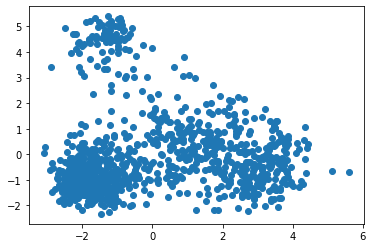

In [30]:
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1])

Not so informative...

Let's make it more beautiful with bokeh!
The plot is now interactive

In [31]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [32]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

# hover a mouse over there and see if you can identify the clusters

Figure(id='1003', ...)

### Visualizing neighbors with UMAP
PCA is nice but it's strictly linear and thus only able to capture coarse high-level structure of the data.

If we instead want to focus on keeping neighboring points near, we could use UMAP, which is itself an embedding method. Here you can read __[more on UMAP (ru)](https://habr.com/ru/company/newprolab/blog/350584/)__ and on __[t-SNE](https://distill.pub/2016/misread-tsne/)__, which is also an embedding.

In [33]:
embedding = umap.UMAP(n_neighbors=5).fit_transform(word_vectors) 

In [35]:
embedding.shape

(1000, 2)

In [34]:
draw_vectors(embedding[:, 0], embedding[:, 1], token=words)

# hover a mouse over there and see if you can identify the clusters

Figure(id='1113', ...)

### Visualizing phrases

Word embeddings can also be used to represent short phrases. The simplest way is to take __an average__ of vectors for all tokens in the phrase with some weights.

This trick is useful to identify what data are you working with: find if there are any outliers, clusters or other artefacts.

Let's try this new hammer on our data!


In [36]:
def get_phrase_embedding(phrase):
    """
    Convert phrase to a vector by aggregating it's word embeddings. See description above.
    """
    # 1. lowercase phrase
    # 2. tokenize phrase
    # 3. average word vectors for all words in tokenized phrase
    # skip words that are not in model's vocabulary
    # if all words are missing from vocabulary, return zeros
    
    vector = np.zeros([model.vector_size], dtype='float32')
    phrase_tokenized = tokenizer.tokenize(phrase.lower())
    phrase_vectors = [model[x] for x in phrase_tokenized if model.has_index_for(x)]
    if len(phrase_vectors) != 0:
        vector = np.mean(phrase_vectors, axis=0)    
    return vector    

In [37]:
get_phrase_embedding(data[402687])

array([-0.18204999,  0.30953574,  0.20861094,  0.07982156, -0.22565515,
       -0.33001748,  1.2495784 ,  0.13134292, -0.33788875,  0.06196944,
       -0.231793  ,  0.09389219, -4.9685497 , -0.23611419, -0.32609668,
       -0.092073  ,  0.4407505 , -0.75413746, -0.5389092 , -0.184752  ,
        0.07867809,  0.20018655, -0.16202375,  0.30375698, -0.41255665],
      dtype=float32)

In [38]:
vector = get_phrase_embedding("I'm very sure. This never happened to me before...")

In [39]:
# let's only consider ~5k phrases for a first run.
chosen_phrases = data[::len(data) // 1000]

# compute vectors for chosen phrases and turn them to numpy array
phrase_vectors = np.asarray([get_phrase_embedding(x) for x in chosen_phrases])

In [40]:
assert isinstance(phrase_vectors, np.ndarray) and np.isfinite(phrase_vectors).all()
assert phrase_vectors.shape == (len(chosen_phrases), model.vector_size)

In [41]:
# map vectors into 2d space with pca, tsne or your other method of choice
# don't forget to normalize

phrase_vectors_2d = umap.UMAP(n_neighbors=3).fit_transform(phrase_vectors)

# phrase_vectors_2d = (phrase_vectors_2d - phrase_vectors_2d.mean(axis=0)) / phrase_vectors_2d.std(axis=0)

In [42]:
draw_vectors(phrase_vectors_2d[:, 0], phrase_vectors_2d[:, 1],
             phrase=[phrase[:50] for phrase in chosen_phrases],
             radius=20,)

Figure(id='1234', ...)

Finally, let's build a simple "similar question" engine with phrase embeddings we've built.

In [43]:
# compute vector embedding for all lines in data
data_vectors = np.vstack([get_phrase_embedding(l) for l in data])

In [44]:
norms = np.linalg.norm(data_vectors, axis=1)

In [45]:
printable_set = set(string.printable)

In [46]:
data_subset = [x for x in data if set(x).issubset(printable_set)]

In [47]:
def find_nearest(query, k=10):
    """
    given text line (query), return k most similar lines from data, sorted from most to least similar
    similarity should be measured as cosine between query and line embedding vectors
    hint: it's okay to use global variables: data and data_vectors. see also: np.argpartition, np.argsort
    """
    query_vector = get_phrase_embedding(query)
    dists = data_vectors.dot(query_vector[:, None])[:, 0] / ((norms+1e-16)*np.linalg.norm(query_vector))
    nearest_elements = dists.argsort(axis=0)[-k:][::-1]
    out = [data[i] for i in nearest_elements]
    return out# <YOUR CODE: top-k lines starting from most similar>

In [48]:
results = find_nearest(query="How do i enter the matrix?", k=10)

print(''.join(results))

assert len(results) == 10 and isinstance(results[0], str)
assert results[0] == 'How do I get to the dark web?\n'
# assert results[3] == 'What can I do to save the world?\n'

How do I get to the dark web?
What universal remote do I need and how do I set it up to a Blaupunkt TV?
How do I connect the ASUS_T00Q to my PC?
How do you print the gridlines in Excel 2010?
How do you print the gridlines in Excel 2007?
How do you print the gridlines in Excel 2003?
I would like to create a new website. What do I have to do?
How do I get the new Neko Atsume wallpapers? How do they work?
I want to experience the 4G network. Do I need to change my SIM card from 3G to 4G?
What do I have to do to sell my photography?



In [49]:
find_nearest(query="How does Twitter work?", k=10)

['How does Twitter work?\n',
 'How does Instagram work?\n',
 'How does WhatsApp work?\n',
 'Did Facebook pay too much for WhatsApp? Why or why not?\n',
 'How does internet work?\n',
 'How does a Demat account work?\n',
 'How does the WhatsApp call work?\n',
 'How does YouTube Offline work?\n',
 'Is xdating a good website? Why or why not?\n',
 'How does internet actually work?\n']

In [52]:
find_nearest(query="Why don't i ask a question myself?", k=10)

["Why don't my parents listen to me?\n",
 "Why don't people appreciate me?\n",
 "Why she don't interact with me?\n",
 "Why don't I get a date?\n",
 "Why don't I get a girlfriend?\n",
 "Why don't I have a girlfriend?\n",
 "Why don't I have a boyfriend?\n",
 "Why don't I like people touching me?\n",
 "Why can't I ask a question anonymously?\n",
 "Why don't you use Facebook much?\n"]

Let's cluster our phrases

In [53]:
from sklearn.cluster import DBSCAN, KMeans

In [54]:
kmeans = KMeans(3)

In [55]:
labels = kmeans.fit_predict(np.asarray(phrase_vectors))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [56]:
_colors = ['red', 'green', 'blue']

In [57]:
draw_vectors(phrase_vectors_2d[:, 0], phrase_vectors_2d[:, 1], color=[_colors[l] for l in labels],
             phrase=[phrase[:50] for phrase in chosen_phrases],
             radius=20,)

Figure(id='1366', ...)

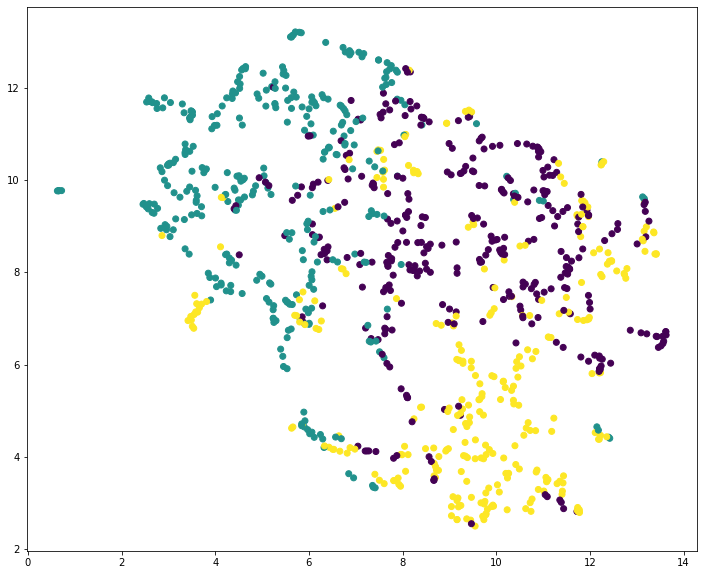

In [58]:
plt.figure(figsize=(12, 10))
plt.scatter(phrase_vectors_2d[:,0], phrase_vectors_2d[:, 1], c=labels.astype(float))

__Now what?__
* Try running TSNE instead of UMAP (it takes a long time)
* Try running UMAP or TSNEon all data, not just 1000 phrases
* See what other embeddings are there in the model zoo: `gensim.downloader.info()`
* Take a look at [FastText](https://github.com/facebookresearch/fastText) embeddings
* Optimize find_nearest with locality-sensitive hashing: use [nearpy](https://github.com/pixelogik/NearPy) or `sklearn.neighbors`.




### Extra: your own word2vec

In [59]:
import torch
import torch.nn as  nn
import torch.autograd  as autograd
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [60]:
from itertools import chain


vocabulary = set(chain.from_iterable(data_tok))

word_to_index = {word: index for index, word in enumerate(vocabulary)} 
index_to_word = {index: word for word, index in word_to_index.items()}
word_counter = {word: 0 for word in word_to_index.keys()}

Generating context pairs:

In [61]:
context_pairs = []
window = 4

for text in data_tok:
    for i, word in enumerate(text):
        context_indices = range(max(0, i - window), min(i + window, len(text)))
        for j in context_indices:
            if j == i:
                continue

            context_pairs.append((word_to_index[word], word_to_index[text[j]]))
            word_counter[word] += 1.0

print(f"Generated {len(context_pairs)} pairs of target and context words.")

Generated 41323344 pairs of target and context words.


Casting everything to `torch.LongTensor`

In [62]:
data_torch = torch.tensor(context_pairs, dtype=torch.long)
X_torch = data_torch[:, 0]
y_torch = data_torch[:, 1]

In [63]:
import torch.nn as nn


class Word2VecModel(nn.Module):
    def __init__(self, embedding_size, vocab_size):
        super().__init__()
        # YOUR CODE HERE
        self.word2emb = nn.Embedding(vocab_size, embedding_size)
        self.emb2ctxt = nn.Linear(embedding_size, vocab_size)

    def forward(self, word):
        # YOUR CODE HERE
        emb = self.word2emb(word)
        return self.emb2ctxt(emb)

In [64]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = Word2VecModel(25, len(word_to_index)).to(device)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

# To reduce learning rate on plateau of the loss functions
lr_scheduler = ReduceLROnPlateau(opt, patience=35)

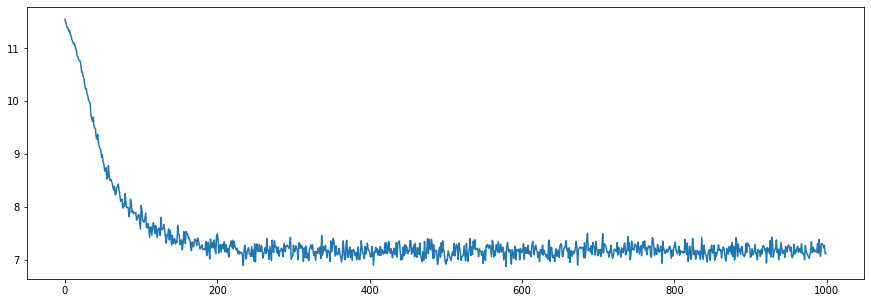

In [65]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


batch_size = 1024
n_steps = 1000
loss_history = []
for i in range(n_steps):
    ix = np.random.randint(0, len(context_pairs), batch_size)
    x_batch = X_torch[ix].to(device)
    y_batch = y_torch[ix].to(device)

    # YOUR CODE HERE
    # predict logits
    y_pred = model(x_batch)

    # YOUR CODE HERE
    # compute loss
    loss = criterion(y_pred, y_batch)

    # YOUR CODE HERE
    # clear gradients
    opt.zero_grad()

    # YOUR CODE HERE
    # compute gradients
    loss.backward()

    # YOUR CODE HERE
    # optimizer step
    opt.step()

    loss_history.append(loss.item())
    lr_scheduler.step(loss_history[-1])

    if (i + 1) % 100 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(15, 5))
        plt.plot(loss_history)
        plt.show()

In [67]:
embedding_matrix = next(model.word2emb.parameters()).detach().cpu()

In [68]:
import torch.nn.functional as F


def find_nearest(word, k=10):
    word_vector = embedding_matrix[word_to_index[word]][None, :]
    dists = F.cosine_similarity(embedding_matrix, word_vector)
    index_sorted = torch.argsort(dists)
    top_k = index_sorted[-k:]
    return [index_to_word[x] for x in top_k.numpy()]

In [69]:
find_nearest("apple", 5)

['breastfeeding', 'doramas', 'pedophilia', 'lmh', 'apple']

It might look not so promising. Remember about the upgrades to word2vec: subsampling and negative sampling.